<a href="https://colab.research.google.com/github/koouu/MNIST/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTの画像分類

In [1]:
#colaboratoryではここにpythonのコードを書いて再生ボタンで実行
print("Hello Would!")

Hello Would!


# データセット  
今回はmnistを使う  
mnistは0～9までの手書き文字が入っているデータセット  
サイズは28×28  
torchvisionのライブラリにもともと用意されている  
trainデータとテストデータに分けて読み込み

In [1]:
from torchvision import datasets,transforms
import torch
train_data = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms.ToTensor())
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_data = datasets.MNIST(root="./dataset", train=False, download=True, transform=transforms.ToTensor())
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# ネットワークの作成

Conv2d が畳み込み  
MaxPool2d がプーリング  
Dropout2d がドロップアウト  
Linear　が全結合

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

これでネットワークを確認できる

In [21]:
net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


最適化、損失関数

In [17]:
import torch.optim as optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.SGD(net.parameters(),lr=0.001,momentum=0.9,nesterov=True)

In [27]:
epochs = 1
print("学習開始")
for epoch in range(epochs):
    running_loss = 0.0
    for i,data in enumerate(train_data_loader):
        train_data, teacher_labels = data
        optimizer.zero_grad()
        outputs = net(train_data)
        loss = criterion(outputs,teacher_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499:
                print("学習進歩 : [epoch={0},step={1}] 学習損失 : {2}".format(epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
        
print("学習終了")

学習開始


RuntimeError: ignored

# 正解率検証

In [19]:
count = 0
total = 0

for data in test_data_loader:
    test_data, teacher_labels = data[0], data[1]
    results = net(test_data)
    _, predicted = torch.max(results.data, 1)
    count += (predicted == teacher_labels).sum()
    total += teacher_labels.size(0)

print("正解率 : {0}/{1} -> {2}".format(count, total, (int(count) / int(total)) * 100))

正解率 : 9569/10000 -> 95.69


ラベル : 7


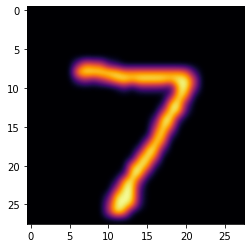

In [12]:
import matplotlib.pyplot as plt
test_itr = iter(test_data_loader)
test_data, labels = test_itr.next()
results = net(test_data)

_, predicted = torch.max(results.data, 1)

plt.imshow(test_data[0].numpy().reshape(28,28), cmap="inferno", interpolation="bicubic")
print("ラベル : {0}".format(predicted[0]))